In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [2]:
sentiment_df = pd.read_excel('sentiment.xlsx')

# Convert date column to datetime format and normalize to date only (no time)
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.normalize()

# List sentiment columns (all columns except Date and any unnamed columns)
sentiment_columns = [col for col in sentiment_df.columns 
                    if col != 'Date' and not col.startswith('Unnamed')]

print("Sentiment Data Columns:")
print(sentiment_df.columns.tolist())
print(f"Sentiment columns to be used: {sentiment_columns}")

# Read the BZ=F CSV file
bz_df = pd.read_csv('BZ=F_15year_daily_data.csv')

# Convert date column to datetime format and normalize to date only (no time)
bz_df['Date'] = pd.to_datetime(bz_df['Date']).dt.normalize()

# Check the data
print("\nSentiment Data:")
print(sentiment_df.head())
print(f"Shape: {sentiment_df.shape}")
print("\nBZ-F Data:")
print(bz_df.head())
print(f"Shape: {bz_df.shape}")

# Check for missing values
print("\nMissing values in Sentiment Data:")
print(sentiment_df.isnull().sum())
print("\nMissing values in BZ-F Data:")
print(bz_df.isnull().sum())

Sentiment Data Columns:
['Unnamed: 0', 'Date', 'Daily_Sum_RavenPack', 'Csum_RavenPack', 'Daily_Sum_FinBERT', 'Csum_FinBERT', 'Daily_Sum_CrudeBERT', 'Csum_CrudeBERT', 'Daily_Sum_CrudeBERT_GT', 'Csum_CrudeBERT_GT', 'Daily_Sum_CrudeBERT_Plus', 'Csum_CrudeBERT_Plus', 'Daily_Sum_CrudeBERT_Plus_GT', 'Csum_CrudeBERT_Plus_GT']
Sentiment columns to be used: ['Daily_Sum_RavenPack', 'Csum_RavenPack', 'Daily_Sum_FinBERT', 'Csum_FinBERT', 'Daily_Sum_CrudeBERT', 'Csum_CrudeBERT', 'Daily_Sum_CrudeBERT_GT', 'Csum_CrudeBERT_GT', 'Daily_Sum_CrudeBERT_Plus', 'Csum_CrudeBERT_Plus', 'Daily_Sum_CrudeBERT_Plus_GT', 'Csum_CrudeBERT_Plus_GT']

Sentiment Data:
   Unnamed: 0       Date  Daily_Sum_RavenPack  Csum_RavenPack  \
0           1 2012-01-01                 0.65            0.65   
1           2 2012-01-02                 0.91            1.56   
2           3 2012-01-03                 0.33            1.89   
3           4 2012-01-04                -0.06            1.83   
4           5 2012-01-05        

In [3]:
start_date = '2012-01-01'
end_date = '2021-04-01'

sentiment_filtered = sentiment_df[(sentiment_df['Date'] >= start_date) & (sentiment_df['Date'] <= end_date)]
bz_filtered = bz_df[(bz_df['Date'] >= start_date) & (bz_df['Date'] <= end_date)]

print(f"Filtered Sentiment Data Shape: {sentiment_filtered.shape}")
print(f"Filtered BZ-F Data Shape: {bz_filtered.shape}")

Filtered Sentiment Data Shape: (3379, 14)
Filtered BZ-F Data Shape: (2307, 6)


In [4]:
print("BZ-F Date Range:")
print(f"Min: {bz_filtered['Date'].min()}, Max: {bz_filtered['Date'].max()}")
print("Sentiment Date Range:")
print(f"Min: {sentiment_filtered['Date'].min()}, Max: {sentiment_filtered['Date'].max()}")

# Print some sample dates from both dataframes
print("\nSample dates from BZ-F:")
print(bz_filtered['Date'].head().tolist())
print("\nSample dates from Sentiment:")
print(sentiment_filtered['Date'].head().tolist())

# Create the merged dataframe using only BZ-F dates (trading days)
sent_df = bz_filtered[['Date']].copy()

# Map each sentiment column to the trading days
for column in sentiment_columns:
    # Create a dictionary to map dates to sentiment values for this column
    sentiment_dict = dict(zip(sentiment_filtered['Date'], sentiment_filtered[column]))
    
    # Map the sentiment values to the trading days
    sent_df[column] = sent_df['Date'].map(sentiment_dict)

# Check the result
print("\nSENT Data:")
print(sent_df.head())
print(f"Shape: {sent_df.shape}")

# Check for missing values in each column
print("\nMissing values in SENT data:")
print(sent_df.isnull().sum())

BZ-F Date Range:
Min: 2012-01-03 00:00:00, Max: 2021-04-01 00:00:00
Sentiment Date Range:
Min: 2012-01-01 00:00:00, Max: 2021-04-01 00:00:00

Sample dates from BZ-F:
[Timestamp('2012-01-03 00:00:00'), Timestamp('2012-01-04 00:00:00'), Timestamp('2012-01-05 00:00:00'), Timestamp('2012-01-06 00:00:00'), Timestamp('2012-01-09 00:00:00')]

Sample dates from Sentiment:
[Timestamp('2012-01-01 00:00:00'), Timestamp('2012-01-02 00:00:00'), Timestamp('2012-01-03 00:00:00'), Timestamp('2012-01-04 00:00:00'), Timestamp('2012-01-05 00:00:00')]

SENT Data:
          Date  Daily_Sum_RavenPack  Csum_RavenPack  Daily_Sum_FinBERT  \
430 2012-01-03                 0.33            1.89                0.5   
431 2012-01-04                -0.06            1.83                1.5   
432 2012-01-05                 0.49            2.32                2.0   
433 2012-01-06                 0.51            2.83                0.0   
434 2012-01-09                 0.96            3.68                0.5   

     

In [5]:
missing_rows = sent_df[sentiment_columns].isnull().any(axis=1).sum()
print(f"\nRows with at least one missing sentiment value: {missing_rows}")

if missing_rows > 0:
    # Option 1: Drop rows with any missing sentiment value
    complete_df = sent_df.dropna()
    print(f"Shape after dropping rows with any missing value: {complete_df.shape}")
    
    # Option 2: Keep rows where at least one sentiment value exists
    partial_df = sent_df.dropna(how='all', subset=sentiment_columns)
    print(f"Shape keeping rows with at least one sentiment value: {partial_df.shape}")
    
    # For this analysis, we'll use the partial approach to keep more data
    sent_df = partial_df
    
    print("\nPercentage of missing values in each column:")
    for col in sentiment_columns:
        missing_pct = sent_df[col].isnull().mean() * 100
        print(f"{col}: {missing_pct:.2f}%")



Rows with at least one missing sentiment value: 1
Shape after dropping rows with any missing value: (2306, 13)
Shape keeping rows with at least one sentiment value: (2306, 13)

Percentage of missing values in each column:
Daily_Sum_RavenPack: 0.00%
Csum_RavenPack: 0.00%
Daily_Sum_FinBERT: 0.00%
Csum_FinBERT: 0.00%
Daily_Sum_CrudeBERT: 0.00%
Csum_CrudeBERT: 0.00%
Daily_Sum_CrudeBERT_GT: 0.00%
Csum_CrudeBERT_GT: 0.00%
Daily_Sum_CrudeBERT_Plus: 0.00%
Csum_CrudeBERT_Plus: 0.00%
Daily_Sum_CrudeBERT_Plus_GT: 0.00%
Csum_CrudeBERT_Plus_GT: 0.00%


In [6]:
sent_df.to_csv('SENT.csv', index=False)
print("\nSENT.csv has been created successfully!")

# Check start and end dates to confirm range
print(f"First date in SENT.csv: {sent_df['Date'].min()}")
print(f"Last date in SENT.csv: {sent_df['Date'].max()}")
print(f"Total rows in SENT.csv: {len(sent_df)}")


SENT.csv has been created successfully!
First date in SENT.csv: 2012-01-03 00:00:00
Last date in SENT.csv: 2021-04-01 00:00:00
Total rows in SENT.csv: 2306


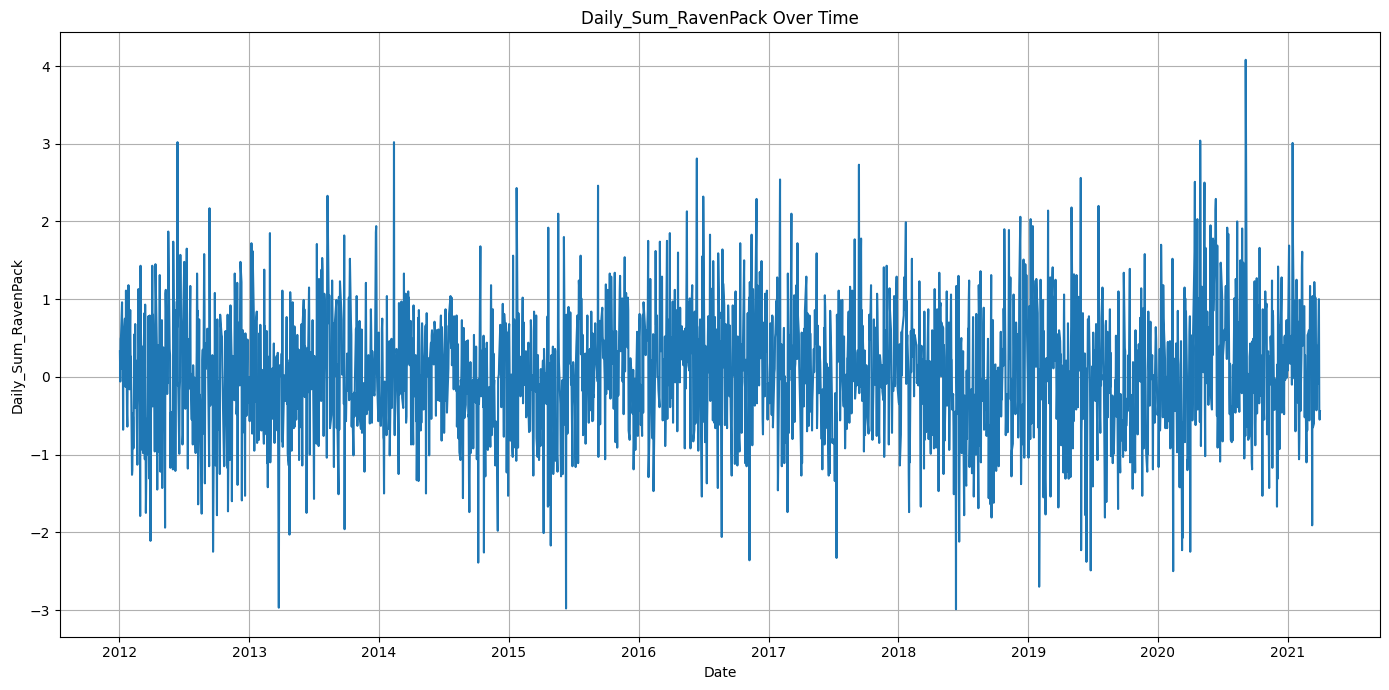


Correlation between sentiment measures:
                             Daily_Sum_RavenPack  Csum_RavenPack  \
Daily_Sum_RavenPack                     1.000000        0.048133   
Csum_RavenPack                          0.048133        1.000000   
Daily_Sum_FinBERT                      -0.001068       -0.176176   
Csum_FinBERT                           -0.043158       -0.933045   
Daily_Sum_CrudeBERT                     0.853472        0.025299   
Csum_CrudeBERT                          0.019721       -0.058709   
Daily_Sum_CrudeBERT_GT                  0.778729        0.035283   
Csum_CrudeBERT_GT                      -0.032721       -0.332422   
Daily_Sum_CrudeBERT_Plus                0.629542        0.055085   
Csum_CrudeBERT_Plus                    -0.005542       -0.171587   
Daily_Sum_CrudeBERT_Plus_GT             0.565701        0.069165   
Csum_CrudeBERT_Plus_GT                 -0.027448       -0.261967   

                             Daily_Sum_FinBERT  Csum_FinBERT  \
Daily_Sum_

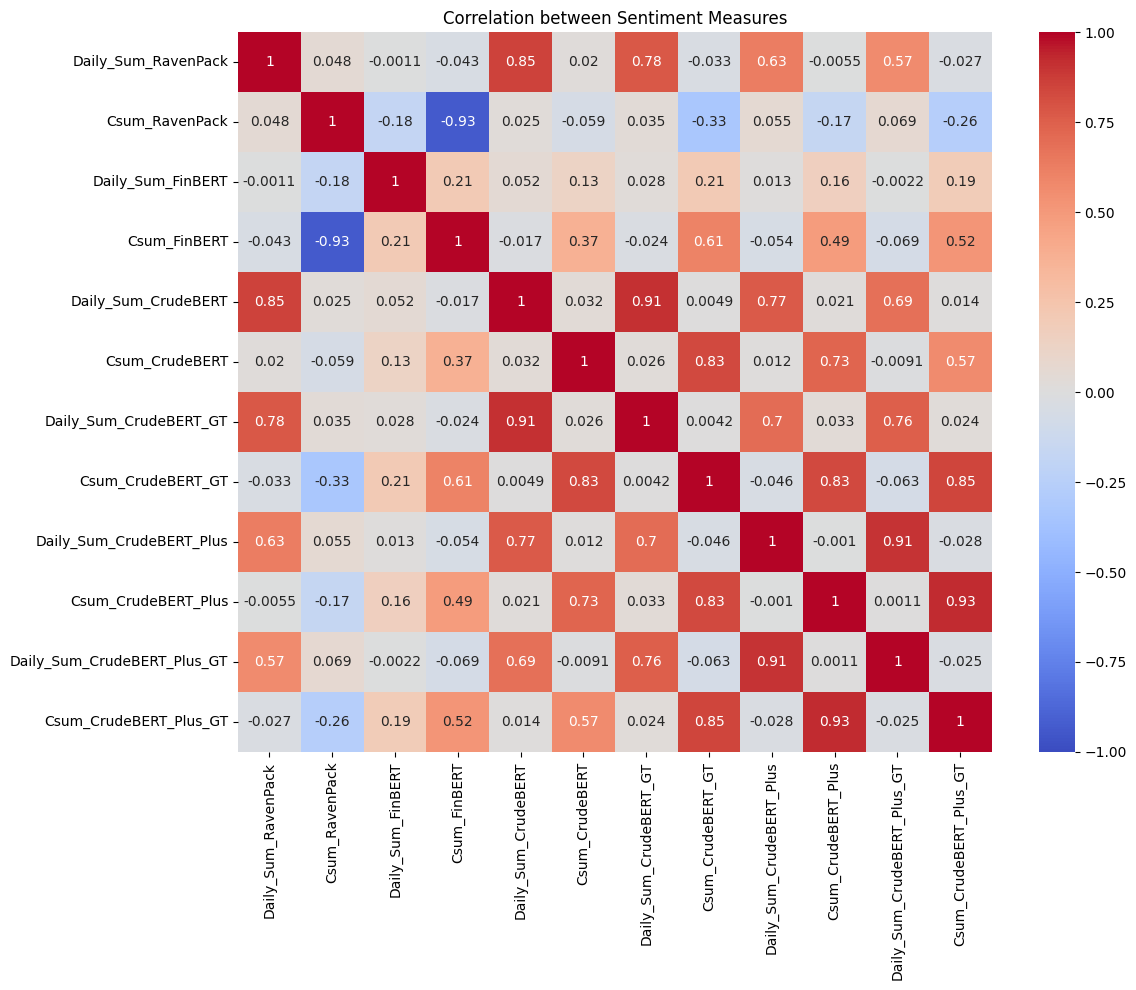

In [7]:
sentinel_column = sentiment_columns[0] if sentiment_columns else None

if len(sent_df) > 0 and sentinel_column and not sent_df[sentinel_column].isnull().all():
    plt.figure(figsize=(14, 7))
    plt.plot(sent_df['Date'], sent_df[sentinel_column])
    plt.title(f'{sentinel_column} Over Time')
    plt.xlabel('Date')
    plt.ylabel(sentinel_column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Show correlation between sentiment measures
    if len(sentiment_columns) > 1:
        print("\nCorrelation between sentiment measures:")
        correlation = sent_df[sentiment_columns].corr()
        print(correlation)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation between Sentiment Measures')
        plt.tight_layout()
        plt.show()
else:
    print("No data to visualize or all sentiment values are missing.")


In [8]:
if len(sent_df) > 0:
    # Check for any gaps in dates
    sent_df_sorted = sent_df.sort_values('Date')
    sent_df_sorted['Next_Date'] = sent_df_sorted['Date'].shift(-1)
    sent_df_sorted['Days_Between'] = (sent_df_sorted['Next_Date'] - sent_df_sorted['Date']).dt.days
    
    # Check if there are any unusually large gaps (more than expected for weekends)
    large_gaps = sent_df_sorted[sent_df_sorted['Days_Between'] > 3]
    if not large_gaps.empty:
        print("\nPotential gaps in data (more than 3 days):")
        print(large_gaps[['Date', 'Next_Date', 'Days_Between']].head(10))  # Show at most 10 gaps
    else:
        print("\nNo unusual gaps found in the trading days.")
    
    # Clean up temporary columns
    sent_df = sent_df[['Date'] + sentiment_columns]
else:
    print("No data to check for completeness. Please fix the previous steps.")



Potential gaps in data (more than 3 days):
          Date  Next_Date  Days_Between
438 2012-01-13 2012-01-17           4.0
462 2012-02-17 2012-02-21           4.0
495 2012-04-05 2012-04-09           4.0
530 2012-05-25 2012-05-29           4.0
598 2012-08-31 2012-09-04           4.0
606 2012-09-13 2012-09-18           5.0
633 2012-10-26 2012-10-31           5.0
645 2012-11-15 2012-11-19           4.0
664 2012-12-14 2012-12-19           5.0
685 2013-01-18 2013-01-22           4.0


In [9]:
if len(sent_df) > 0:
    print("\nSummary Statistics for Sentiment Measures:")
    for column in sentiment_columns:
        if not sent_df[column].isnull().all():
            print(f"\n{column}:")
            print(sent_df[column].describe())
    
    # Count trading days per year
    sent_df['Year'] = sent_df['Date'].dt.year
    year_counts = sent_df['Year'].value_counts().sort_index()
    print("\nTrading days per year:")
    print(year_counts)
    
    # Cleanup temporary column
    sent_df = sent_df.drop('Year', axis=1)
else:
    print("No data for summary statistics.")

print("\nFinal SENT.csv data sample:")
print(sent_df.head(5))


Summary Statistics for Sentiment Measures:

Daily_Sum_RavenPack:
count    2306.000000
mean        0.053395
std         0.819614
min        -2.990000
25%        -0.490000
50%         0.070000
75%         0.577500
max         4.080000
Name: Daily_Sum_RavenPack, dtype: float64

Csum_RavenPack:
count    2306.000000
mean       65.730828
std        55.922653
min       -11.030000
25%        12.152500
50%        61.395000
75%       112.850000
max       186.240000
Name: Csum_RavenPack, dtype: float64

Daily_Sum_FinBERT:
count    2306.000000
mean       -0.834779
std         1.323253
min        -9.000000
25%        -1.500000
50%        -1.000000
75%         0.000000
max         3.000000
Name: Daily_Sum_FinBERT, dtype: float64

Csum_FinBERT:
count    2306.000000
mean     -916.805941
std       679.222187
min     -2267.000000
25%     -1501.500000
50%      -849.750000
75%      -289.500000
max         3.000000
Name: Csum_FinBERT, dtype: float64

Daily_Sum_CrudeBERT:
count    2306.000000
mean       -0